In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

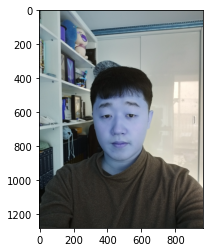

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/exploration/image2.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 부름 - 디폴트 값이 bgr로 되어있음
img_show = img_bgr.copy()              # 원본은 놔두고 카피본만 사용
plt.imshow(img_bgr)
plt.show()

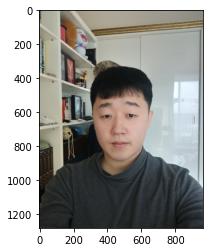

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #BGR을 RGB 형태로 CONVERT가 필요
plt.imshow(img_rgb)
plt.show()

# 얼굴구간 설정

In [4]:
detector_hog = dlib.get_frontal_face_detector()   # detector HOG를 선언 = Histogram of Oriented Gradients
print("~")             

# .get_frontal_face_detector메서드는 기본 얼굴 검출기를 나타냄
# HOG의 방법은 영상 밝기 변화의 방향을 그래디언트로 표현하고 객체를 찾아냄

~


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)   #dlib는 rgb이미지를 입력으로 받기때문에 변환필수
dlib_rects = detector_hog(img_rgb, 1)                # (이미지, 이미지 피라미드의 수)
print("~")

# 이미지피라미드 =  이미지를 upsampling하는 방법을 통해 크기를 키우는 것
# upsampling = 데이터가 더 적은쪽의 표본을 많은 쪽과 같게 만드는 방법(적은쪽의 데이터를 키우는 방법을 사용하여)

~


rectangles[[(312, 527) (633, 848)]]


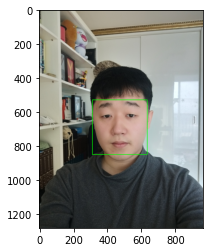

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()                    # 얼굴영역 박싱과정
    r = dlib_rect.right()                  # 왼쪽 상단부터 오른쪽 하단까지 범위를 지정함으로써 사각형을 만듦
    b = dlib_rect.bottom()

    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)      #img_show는 bgr의 카피버전
    #cv2.rectangle을 사용하여 사각형을 그림 (좌상, 우하, 초록색, 두께, 라인타입?)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)                          
plt.imshow(img_show_rgb)         
plt.show()

### 초록색 사각형이 생겼다. 이 사진 이전에는 다른 사진으로 했는데, 제대로 된 값이 나오지 않았다. 둘을 비교해보니 이 사진에 비해 다른 사진은 아무 가까운 거리에서 찍어서 사진이 크게 나왔었는데, 그게 문제였던 것 같다.

# 랜드마크 - 이목구비 위치 추론

In [7]:
#dlib에서 제공하는 모델을 가지고 옴
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("~")

~


In [8]:
list_landmarks = []

for dlib_rect in dlib_rects:                              # 얼굴 영역 박스 마다 랜드마크를 찾아냄
    points = landmark_predictor(img_rgb, dlib_rect)       #dlib_rect는 hog를 선언한 부분
    # face landmark 좌표를 저장해둡니다                   = .get_frontal_face_detector
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


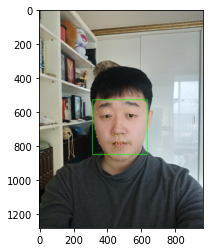

In [9]:
#이목구비 출력 = 랜드마크 출력
for landmark in list_landmarks:     
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  #원형 모양으로(img_show = bgr의 카피)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 희미하지만 이목구비에 점이 찍혔다.

# 좌표확인

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])                                     # 코의 index는 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()                                #hog 선언부분 = .get_frontal_face_detector
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(458, 709)
(x,y) : (458,548)
(w,h) : (322,322)


# 코의 중심점이 458, 709로 나옴

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/exploration/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)    # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

#스티커 이미지를 읽고 윗단계에서 계산한 사이즈로 리사이즈함

(322, 322, 3)


#### 스티커 이미지 불러오기

In [12]:
#x,y좌표 조정 = 이미지 시작점이 좌상 이기때문에

refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (297,548)


In [13]:
#음수로 벗어나지 않아서 사용하지 않음, 음수일 경우 사용 = ndarray는 음수인덱스에 접근 불가

#if refined_x < 0: 
#    img_sticker = img_sticker[:, -refined_x:]
#    refined_x = 0
#if refined_y < 0:
#    img_sticker = img_sticker[-refined_y:, :]
#    refined_y = 0
#
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [14]:
#img_show[from:to] 형식

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("~")

#sticker_area는 원본이미지에서 스티커를 적용할 위치를 자른 이미지

~


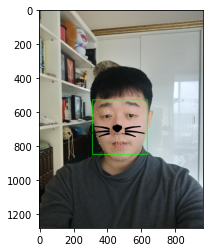

In [15]:
#결과물 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

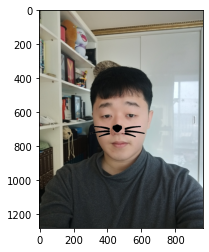

In [16]:
#결과물 출력_초록박스 제거
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# -------------------------------측면------------------------------------------

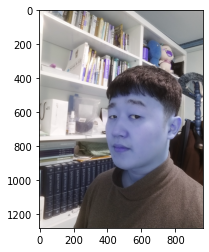

In [17]:
my_image_path4 = os.getenv('HOME')+'/aiffel/exploration/image4.png'
img_bgr4 = cv2.imread(my_image_path4)    # OpenCV로 이미지를 부름 - 디폴트 값이 bgr로 되어있음
img_show4 = img_bgr4.copy()              # 원본은 놔두고 카피본만 사용
plt.imshow(img_bgr4)
plt.show()

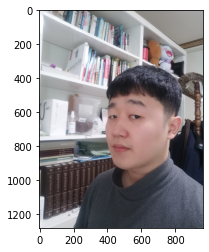

In [18]:
img_rgb4 = cv2.cvtColor(img_bgr4, cv2.COLOR_BGR2RGB) #BGR을 RGB 형태로 CONVERT가 필요
plt.imshow(img_rgb4)
plt.show()

In [19]:
detector_hog4 = dlib.get_frontal_face_detector()   # detector HOG를 선언 = Histogram of Oriented Gradients
print("~")             

# .get_frontal_face_detector메서드는 기본 얼굴 검출기를 나타냄
# HOG의 방법은 영상 밝기 변화의 방향을 그래디언트로 표현하고 객체를 찾아냄

~


In [20]:
img_rgb4 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)   #dlib는 rgb이미지를 입력으로 받기때문에 변환필수
dlib_rects4 = detector_hog4(img_rgb, 1)                # (이미지, 이미지 피라미드의 수)
print("~")

# 이미지피라미드 =  이미지를 upsampling하는 방법을 통해 크기를 키우는 것
# upsampling = 데이터가 더 적은쪽의 표본을 많은 쪽과 같게 만드는 방법(적은쪽의 데이터를 키우는 방법을 사용하여)

~


rectangles[[(312, 527) (633, 848)]]


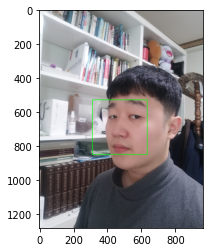

In [21]:
print(dlib_rects4)   

for dlib_rect in dlib_rects4:
    l = dlib_rect.left()
    t = dlib_rect.top()                    # 얼굴영역 박싱과정
    r = dlib_rect.right()                  # 왼쪽 상단부터 오른쪽 하단까지 범위를 지정함으로써 사각형을 만듦
    b = dlib_rect.bottom()

    
    cv2.rectangle(img_show4, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)      #img_show는 bgr의 카피버전
    #cv2.rectangle을 사용하여 사각형을 그림 (좌상, 우하, 초록색, 두께, 라인타입?)
    
img_show_rgb4 =  cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB)                          
plt.imshow(img_show_rgb4)         
plt.show()

### 초록색 사각형이 얼굴이 아닌 부분을 포함하는 문제가 발생함

In [22]:
#dlib에서 제공하는 모델을 가지고 옴
model_path4 = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor4 = dlib.shape_predictor(model_path4)
print("~")

~


In [23]:
list_landmarks4 = []

for dlib_rect4 in dlib_rects4:                              # 얼굴 영역 박스 마다 랜드마크를 찾아냄
    points4 = landmark_predictor(img_rgb4, dlib_rect4)       #dlib_rect는 hog를 선언한 부분
    # face landmark 좌표를 저장해둡니다                   = .get_frontal_face_detector
    list_points4 = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks4.append(list_points)

print(len(list_landmarks4[0]))

68


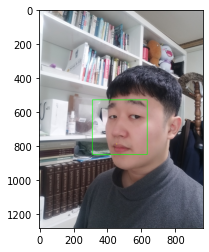

In [24]:
#이목구비 출력 = 랜드마크 출력
for landmark4 in list_landmarks4:     
    for point4 in landmark4:
        cv2.circle(img_show4, point, 2, (0, 255, 255), -1)  #원형 모양으로(img_show = bgr의 카피)

img_show_rgb4 = cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb4)
plt.show()

### 측면 사진을 찍었을 때 랜드마크가 하나만 나타나는 것을 확인할 수 있음.
### 얼굴을 인식할 때 얼굴이 아닌 부분이 존재하기 때문에 랜드마크를 파악할 수 없는 것으로 보임

# -------------------------------밝기---------------------------------------

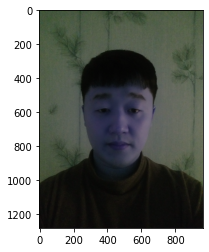

In [25]:
my_image_path6 = os.getenv('HOME')+'/aiffel/exploration/image6.png'
img_bgr6 = cv2.imread(my_image_path6)    # OpenCV로 이미지를 부름 - 디폴트 값이 bgr로 되어있음
img_show6 = img_bgr6.copy()              # 원본은 놔두고 카피본만 사용
plt.imshow(img_bgr6)
plt.show()

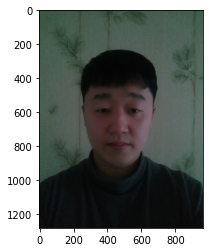

In [26]:
img_rgb6 = cv2.cvtColor(img_bgr6, cv2.COLOR_BGR2RGB) #BGR을 RGB 형태로 CONVERT가 필요
plt.imshow(img_rgb6)
plt.show()

In [27]:
detector_hog6 = dlib.get_frontal_face_detector()   # detector HOG를 선언 = Histogram of Oriented Gradients
print("~")             

# .get_frontal_face_detector메서드는 기본 얼굴 검출기를 나타냄
# HOG의 방법은 영상 밝기 변화의 방향을 그래디언트로 표현하고 객체를 찾아냄

~


In [28]:
img_rgb6 = cv2.cvtColor(img_bgr6, cv2.COLOR_BGR2RGB)   #dlib는 rgb이미지를 입력으로 받기때문에 변환필수
dlib_rects6 = detector_hog6(img_rgb, 1)                # (이미지, 이미지 피라미드의 수)
print("~")

# 이미지피라미드 =  이미지를 upsampling하는 방법을 통해 크기를 키우는 것
# upsampling = 데이터가 더 적은쪽의 표본을 많은 쪽과 같게 만드는 방법(적은쪽의 데이터를 키우는 방법을 사용하여)

~


rectangles[[(312, 527) (633, 848)]]


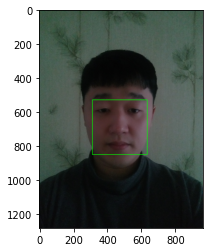

In [29]:
print(dlib_rects6)   

for dlib_rect6 in dlib_rects6:
    l = dlib_rect.left()
    t = dlib_rect.top()                    # 얼굴영역 박싱과정
    r = dlib_rect.right()                  # 왼쪽 상단부터 오른쪽 하단까지 범위를 지정함으로써 사각형을 만듦
    b = dlib_rect.bottom()

    
    cv2.rectangle(img_show6, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)      #img_show는 bgr의 카피버전
    #cv2.rectangle을 사용하여 사각형을 그림 (좌상, 우하, 초록색, 두께, 라인타입?)
    
img_show_rgb6 =  cv2.cvtColor(img_show6, cv2.COLOR_BGR2RGB)                          
plt.imshow(img_show_rgb6)         
plt.show()

### 얼굴인식을 생각보다 잘 하는걸 볼 수 있다.
### 어두우면 잘 잡히지 않는다고 하는데, 아직도 밝은 것 같다 

In [30]:
#dlib에서 제공하는 모델을 가지고 옴
model_path6 = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor6 = dlib.shape_predictor(model_path)
print("~")

~


In [31]:
list_landmarks6 = []

for dlib_rect6 in dlib_rects6:                              # 얼굴 영역 박스 마다 랜드마크를 찾아냄
    points6 = landmark_predictor6(img_rgb6, dlib_rect)       #dlib_rect는 hog를 선언한 부분
    # face landmark 좌표를 저장해둡니다                   = .get_frontal_face_detector
    list_points6 = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks6.append(list_points6)

print(len(list_landmarks6[0]))

68


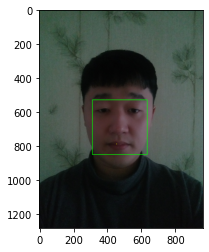

In [32]:
#이목구비 출력 = 랜드마크 출력
for landmark6 in list_landmarks6:     
    for point6 in landmark6:
        cv2.circle(img_show6, point, 2, (0, 255, 255), -1)  #원형 모양으로(img_show = bgr의 카피)

img_show_rgb6 = cv2.cvtColor(img_show6, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb6)
plt.show()

### 랜드마크가 윗입술쪽에 하나 잡힌 것을 볼 수 있다. 
### 일관적으로 어두워서 명암에 차이에 따른 이목구비를 구분하지 못하는 것 같다.


# 종합
#### 얼굴 각도가 정면이 아닐 경우 얼굴의 일부를 잘못 인지할 수 있다
#### 이미지 밝기가 밝거나 어두울 때 얼굴 인식은 되지만, 랜드마크가 거의 찍히지 않는다
#### 너무 가까이에서 찍을 경우 얼굴 자체를 인식하지 못하는 문제가 발생하기도 한다.